In [2]:
# setup
import pandas as pd
import numpy as np
from DktRunner import DktRunner
filename = "/home/nicolagp/repos/learner-performance-prediction/data/2015_CN_AZUL/preprocessed_data_test.csv"
df = pd.read_csv(filename, delimiter="\t")
df.head()

user_id  item_id  timestamp  correct  skill_id      DKT2
0    19308     1034          0        0        18  0.223891
1    19308     1035          0        0        10  0.221908
2    19308     1038          0        0        28  0.284956
3    19308     1028          0        1        22  0.284606
4    19308     1020          0        0        21  0.299299

# Defining Influence
According to Deep Knowledge Tracing, we can define an influence $J_{i,j}$ to every pair of exercises $i, j$:

$$J_{i,j} = \frac{y(i|j)}{\sum_{k} y(i|k)}$$

### Generating samples to run through model
We need to come up with $(i,j)$ pairs for every pair of items. These samples are run through the trained model and the DKT value for exercise $i$ is $y(i|j)$

In [5]:
# get dictionary of items to skills
items = df.item_id.unique()
g = df.groupby("item_id")
itos = {i:g.get_group(i)["skill_id"].iloc[0] for i in items}

count = 0
influences = pd.DataFrame(columns=["user_id", "item_id", "timestamp", "correct", "skill_id"])
for i in items:
    for j in items:
        if i != j:
            influences.loc[count, ["user_id", "item_id", "timestamp", "correct", "skill_id"]] = [count, j, 0, 1, itos[j]]
            influences.loc[count+1, ["user_id", "item_id", "timestamp", "correct", "skill_id"]] = [count, i, 0, 0, itos[i]]
            count += 2

influences.head()

In [19]:
influences.item_id = influences.item_id.apply(int)
influences.user_id = influences.user_id.apply(int)
influences.skill_id = influences.skill_id.apply(int)
influences.timestamp = influences.timestamp.apply(int)
influences.correct = influences.correct.apply(int)

### Run samples through model

In [7]:
path = "../save/dkt/2015_CN_AZUL"
runner = DktRunner(path)

In [25]:
influences["DKT"] = runner.predict(influences)
influences

user_id  item_id  timestamp  correct  skill_id       DKT
0            0     1035          0        1        10  0.305947
1            0     1034          0        0        18  0.327709
2            2     1038          0        1        28  0.761602
3            2     1034          0        0        18  0.264814
4            4     1028          0        1        22  0.214774
...        ...      ...        ...      ...       ...       ...
36175    36174     1418          0        0        21  0.333694
36176    36176     1421          0        1        29  0.165959
36177    36176     1418          0        0        21  0.426726
36178    36178     1412          0        1         8  0.362917
36179    36178     1418          0        0        21  0.445754

[36180 rows x 6 columns]

## Conditional Probability Matrix
Generate matrix where each entry i,j represents $y(i|j)$

In [68]:
def get_Y(df):
    """
    df: dataframe with input+output of DKT model
    returns a matrix of Y_i,j = y(i|j) for i,j in 1...n
    and a mapping of indices to item_ids
    """
    items = df.item_id.unique()
    shape = (len(items), len(items))
    mapping = {k:v for k,v in enumerate(items)}
    Y = np.zeros(shape)
    j = df.loc[::2]["item_id"].values
    i = df.loc[1::2]["item_id"].values
    df = df.loc[1::2]
    df["i"] = i
    df["j"] = j

    for i in range(shape[0]):
        for j in range(shape[1]):
            if i != j:
                Y[i, j] = df[(df["i"] == mapping[i]) & (df["j"] == mapping[j])]["DKT"].iloc[0]

    return Y, mapping

Y, mapping = get_Y(influences)

## Visualizing influence between pairs of items

In [69]:
def get_pairs(Y):
    pairs = np.zeros((135, 135))
    rowsums = Y.sum(axis=1)
    for i in range(135):
        for j in range(135):
            pairs[i,j] = Y[i,j]/rowsums[i]
    
    return pairs
    
pairs = get_pairs(Y)

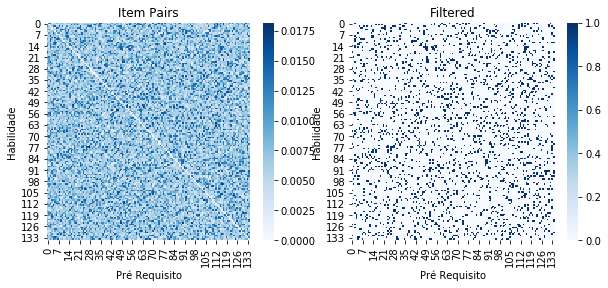

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
c="Blues"
filtered = pairs > 0.0125

sns.heatmap(pairs, cmap=c, ax=ax1)
ax1.set_title("Item Pairs")
ax1.set_xlabel("Pré Requisito")
ax1.set_ylabel("Habilidade")

sns.heatmap(filtered, cmap=c, ax=ax2)
ax2.set_title("Filtered")
ax2.set_xlabel("Pré Requisito")
ax2.set_ylabel("Habilidade")

plt.savefig("test.jpg", dpi=400)
plt.show()

## Inferring skill relations from items

In [97]:
from itertools import product

In [81]:
pair_df = pd.DataFrame(pairs, index=items, columns=items)

In [113]:
g = df.groupby("item_id")
itos = {i:g.get_group(i)["skill_id"].iloc[0] for i in items}

def y(i,j, itos, pairs, mapping):
    """
    i,j: ints, skills to compute
    iots: mapping of items to skills
    pairs: matrix with calculated item influences
    mapping: maps item_ids to row,col indices
    """
    # function to get a list of all items that match a certain skill
    get_items = lambda x: [k for k,v in itos.items() if v == x]
    items_i = get_items(i)
    items_j = get_items(j)
    # cartesian product of items i,j
    prods = list(product(items_i, items_j))
    s = 0
    for p in prods:
        s += pairs[mapping[p[0]], mapping[p[1]]]

    return s/len(prods)


def skills(itos, pairs, mapping):
    """
    i,j: ints, skills to compute
    iots: mapping of items to skills
    pairs: matrix with calculated item influences
    mapping: maps item_ids to row,col indices
    """
    mat = np.zeros((30,30))

    for i in range(30):
        for j in range(30):
            if i != j:
                mat[i,j] = y(i+1,j+1,itos,pairs,mapping)
    return mat

skills = skills(itos, pairs, {v:k for k,v in mapping.items()})

## Visualizing skill pairs

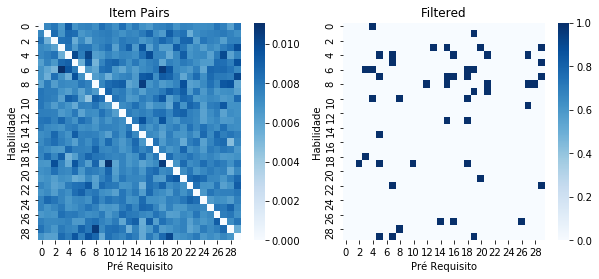

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
c="Blues"
filtered = skills > 0.009

sns.heatmap(skills, cmap=c, ax=ax1)
ax1.set_title("Item Pairs")
ax1.set_xlabel("Pré Requisito")
ax1.set_ylabel("Habilidade")

sns.heatmap(filtered, cmap=c, ax=ax2)
ax2.set_title("Filtered")
ax2.set_xlabel("Pré Requisito")
ax2.set_ylabel("Habilidade")

plt.savefig("test.jpg", dpi=400)
plt.show()

In [118]:
# save matrix as pickle
import pickle
pickle.dump(skills, open("skill_influences.pkl", "wb"))